In [2]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np


"Machine learning tools"

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

#TODO: Adapt if PCA is used or not

Useful functions to select, read and play the dataset sounds are provided in the ``classification`` directory. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 3. Probability vector and memory  [~30min-1h] </font> <br>

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

<font size=5 color=#009999> 3.1. Probability vector </font> <br>

A clear drawback of the models considered in ``hands_on_classif2_audio_student.ipynb`` is that they only output the most probable class, but do not provide any confidence estimate of this prediction. It is generally better to output a vector of probabilities for all the classes at each prediction, hence allowing the models to hesitate between different classes. 
Remember a vector of probability can be defined as 

\begin{equation*}
    \mathbb P \{ i \} \in [0,1], ~~\sum_i \mathbb P \{ i \} = 1. 
\end{equation*}

There are many ways to do so:

- **Adapt the models**, e.g. for the ``KNN`` classifier, give the probability of class ``i`` as the ratio between the number of neighbours with label ``i`` and the total number of considered neighbours ``K``.
- **Use other models**: a ``CNN`` classifier is suited for outputting probability values for each class.
- **Compare with old predictions**: the probability of class ``i`` may simply be given as the ratio of its appearances in the (arbitrarily chosen) ``N`` last predictions.

The last bullet implies the use of old predictions to compute a probability estimate. This leads to the notion of memory in the predictions, that we discuss in the second part of this notebook.

Let us start by creating a dataset ``myds`` and taking the model trained in ````hands_on_classif2_audio.ipynb````.

Don't forget to normalize your feature vectors as well as reduce their dimensionality if you trained your model with such data.

In [118]:

import pickle

### TO COMPLETE - Uncomment the following line
#model = pickle.load(open('/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/classification/data/models/KNN_noPCA.pickle', 'rb'))
model = pickle.load(open('data/models/RF_model.pkl', 'rb'))
normalize = True

pca = None
#pca = pickle.load(open('data/models/pca_5FV.pickle', 'rb')) # Write your path to the model here!

print(model)
print(pca)

"Creation of the dataset"
myds = Feature_vector_DS(
    dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0, normalize=normalize, pca=pca,
)


RandomForestClassifier(max_depth=8, min_samples_leaf=13, min_samples_split=3,
                       n_estimators=150)
None


Open-Source code makes life easy! The ``KNeighborsClassifier`` from Sklearn already contains a ``predict_proba`` method. Start getting some intuition on this probability vector by playing with the chosen feature vector. <br>

Run the following code many times by changing  ``cls_index``. <br>

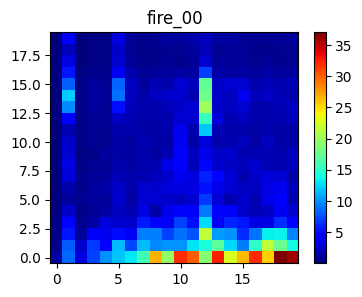

Class predicted by KNN: fire


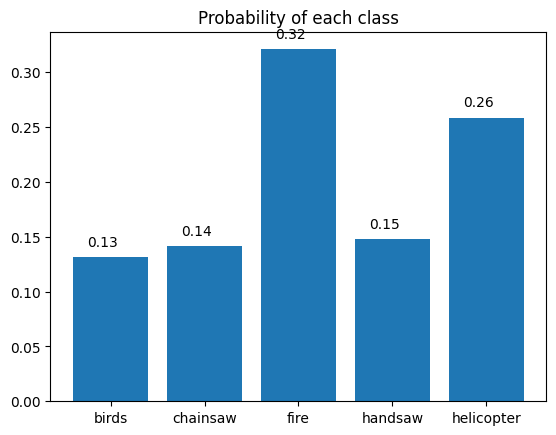

In [6]:
### TO RUN
cls_index = ["fire", 0]
myds.display(cls_index)
thisfv = myds.__getitem__(cls_index).reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

#Warning: need to skip PCA otherwise mat have not the right shape
prediction_knn = model.predict(mat)
print("Class predicted by KNN:", prediction_knn[0])

proba_knn = model.predict_proba(mat)
plt.figure()
plt.bar(classnames, proba_knn[0])
plt.title("Probability of each class")
#Add the proba value on the plot
for i, v in enumerate(proba_knn[0]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.show()


**Question**:
When the classifier miss-predicts, how distributed is the probability vector? Is it good news? How can we exploit that probability distribution for the prediction?

In [7]:
### TO COMPLETE
# Answer the question above


### Answer
* Miss-prediction for chainsaw: helicopter. The proba for chainsaw is 0.49 and the proba for helicopter is 0.51. It means that both features are near in the features vector space.
* Miss-prediction for fire: helicopte. Birds: 0.1, Chainsaw: 0.1, fire: 0.3, handsaw: 0, helicopter: 0.5. It means that the model sees a lot more "helicopter information" in fire sound than fire itself.
* Miss-prediction for handsaw: chainsaw. birds: 0.29, chainsaw: 0.39, fire: 0, handsaw: 0.31, helicopter: 0. Same the previous but with chainsaw and handsaw. \

These informations are good news, because it shows that the model's wrong predictions have a non negligible probability for the correct or other features. This information can be used to express the uncertainity of the model. For example, with the chainsaw missprediction with helicopter, both probabilies were really close, so we could add a layer to our model that don't accept the prediction because it is too much uncertain.

<font size=6 color=#009999> 3.2. Memory </font> <br>

No matter if the predictions are one class only or probability vectors, as it is natural that consecutive feature vectors belong to the same class if the sound type changes slowlier than the duration of a feature vector, it can be helpful to link consecutive predictions and see how similar they are to either strengthen or decrease our confidence in the current guess. <br>

Here, we will compare the predictions made on consecutive feature vectors belonging to the same 5s-long sound. 
Run the following code with different ``class_id``'s and different ``num``.

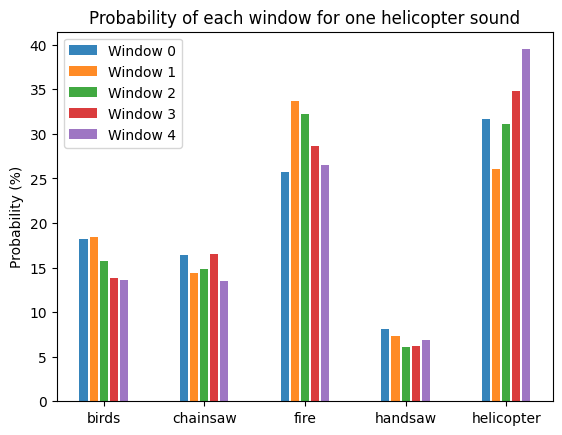

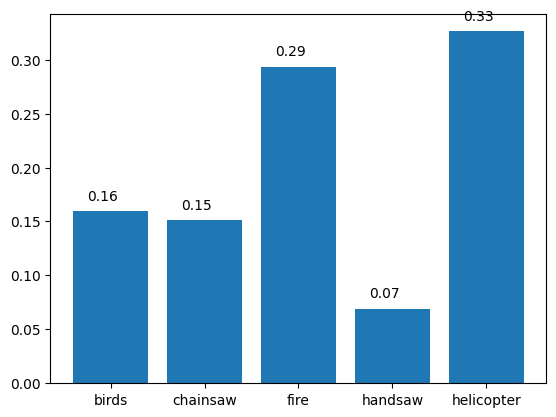

In [116]:
### TO RUN
num = 0  # 0 (default), 1, ..., 3
#What does num correspond to?
# num is the index of the sound in the dataset

classname = "helicopter"
sound = dataset[classname, num]
audio = AudioUtil.open(sound)
audio = AudioUtil.resample(audio, 11025)
#AudioUtil.play(audio)


"Bar charts for each window"
n_win = 5
probs = np.zeros((n_win, len(classnames)))
for window in range(n_win):
    sub_aud = (audio[0][window * 11025 :], audio[1])
    sub_aud = AudioUtil.pad_trunc(sub_aud, 950)
    sgram = AudioUtil.melspectrogram(sub_aud, Nmel=20)
    #plot the spectrogram
    #plt.figure()
    #plt.imshow(sgram, origin="lower")

    ncol = int(1000 * 11025 / (1e3 * 512))
    sgram = sgram[:, :ncol]
    fv = sgram.reshape(-1)
    #fv = myds.__getitem__(cls_index).reshape(-1)
    #mat = np.zeros((2, len(fv)))
    #mat[0] = fv

    #adapt if PCA is used #TODO: TO CORRECT
    if pca is not None:
        fv = pca.transform([fv])[0]

    ### TO COMPLETE - Eventually normalize and reduce feature vector dimensionality
    #Normalize the vector
    fv = fv / np.linalg.norm(fv)

    probs[window, :] = model.predict_proba([fv])[0]
    #probs[window, :] = model.predict_proba([fv])

    #print(probs[window, :])

"Mean bar chart"
plt.figure()
for window in range(n_win):
    plt.bar(
        np.arange(len(classnames)) * 2 * n_win + window,
        probs[window, :] * 100,
        alpha=0.9,
        label=f"Window {window}",
    )
plt.legend()
plt.gca().set_xticks(np.arange(len(classnames)) * 2 * n_win + 2)
plt.gca().set_xticklabels(classnames)
plt.title(f"Probability of each window for one {classname} sound")
plt.ylabel("Probability (%)")
plt.savefig(f"figures/proba_windows_{classname}.pdf")
plt.show()

"Mean bar chart"
plt.figure()
plt.bar(np.arange(len(classnames)), np.mean(probs, axis=0))
plt.gca().set_xticks(np.arange(len(classnames)))
plt.gca().set_xticklabels(classnames)
#Add the proba value on the plot
for i, v in enumerate(np.mean(probs, axis=0)):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.show()

In [113]:
# Parameters

classnames = ["birds", "chainsaw", "fire", "handsaw", "helicopter"]
num_range = range(1, 40)  # Assuming 40 audio files to process

# Dictionary to store results
def get_results_dic(dataset, n_win, classname):
    results_dict = {classname: {"predictions": 0} for classname in classnames}
    
    for num in num_range:
        # Load sound for the current num
        sound = dataset[classname, num]
        audio = AudioUtil.open(sound)
        audio = AudioUtil.resample(audio, 11025)

        # If n_win is 0, treat the entire audio file as one "window" without splitting
        # Initialize probabilities for the windows
        probs = np.zeros((n_win, len(classnames)))

        for window in range(n_win):
            # Extract audio for the current window
            start_idx = window * 11025
            sub_aud = (audio[0][start_idx:], audio[1])
            sub_aud = AudioUtil.pad_trunc(sub_aud, 950)
            
            # Compute mel spectrogram for the window
            sgram = AudioUtil.melspectrogram(sub_aud, Nmel=20)
            ncol = int(1000 * 11025 / (1e3 * 512))
            sgram = sgram[:, :ncol]
            fv = sgram.reshape(-1)
            
            # Apply PCA if needed (ensure it results in 400 features)
            if pca is not None:
                fv = pca.transform([fv])[0]
            
            # Normalize the feature vector
            fv = fv / np.linalg.norm(fv)
            
            
            # Predict probabilities for the current window
            probs[window, :] = model.predict_proba([fv])[0]
            #print(probs[window, :])

        # Compute mean probabilities over all windows (if needed, but you can skip this if not required)
        mean_probs = np.mean(probs, axis=0)
        #print(mean_probs)
        
        # Determine the predicted class for this num and increment the counter
        predicted_class_idx = np.argmax(mean_probs)
        predicted_class = classnames[predicted_class_idx]
        results_dict[predicted_class]["predictions"] += 1

    return results_dict



classnames = ["birds", "chainsaw", "fire", "handsaw", "helicopter"]
classname = "helicopter"

results_dict_1 = get_results_dic(dataset, 1, classname)
results_dict_2 = get_results_dic(dataset, 2, classname)
results_dict_3 = get_results_dic(dataset, 3, classname)
results_dict_4 = get_results_dic(dataset, 4, classname)
results_dict_5 = get_results_dic(dataset, 5, classname)

#Display results
print("\nResults Dictionary 0:")
for c, data in results_dict_1.items():
    print(f"{c}:")
    print(f"  Total Predictions: {data['predictions']}")


# Display results
print("\nResults Dictionary 5:")
for c, data in results_dict_5.items():
    print(f"{c}:")
    print(f"  Total Predictions: {data['predictions']}")




Results Dictionary 0:
birds:
  Total Predictions: 1
chainsaw:
  Total Predictions: 4
fire:
  Total Predictions: 3
handsaw:
  Total Predictions: 0
helicopter:
  Total Predictions: 31

Results Dictionary 5:
birds:
  Total Predictions: 1
chainsaw:
  Total Predictions: 3
fire:
  Total Predictions: 4
handsaw:
  Total Predictions: 0
helicopter:
  Total Predictions: 31


helicopter


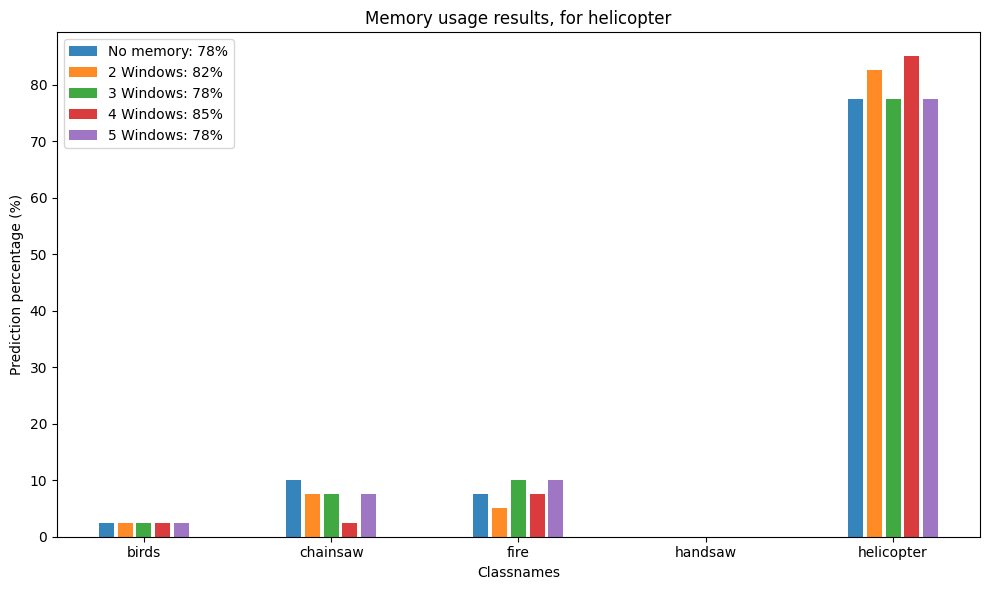

In [114]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(classnames, classname, *results_dicts):
    print(classname)
    """
    Plots a bar chart comparing the total prediction counts for each classname across multiple dictionaries.
    
    Parameters:
    - classnames (list): List of labels for the x-axis.
    - *results_dicts (dict): Variable number of dictionaries containing the results to plot.
    """
    # Ensure at most 6 dictionaries are passed
    if len(results_dicts) > 6:
        raise ValueError("The function can accept a maximum of 6 dictionaries.")

    # Create a bar width and position offsets for up to 6 dictionaries
    bar_width = 0.15
    n_win = len(results_dicts)  # Number of "windows" corresponds to the number of dictionaries
    
    # Prepare figure
    plt.figure(figsize=(10, 6))


    # Loop through each dictionary and plot the total prediction counts
    for idx, results_dict in enumerate(results_dicts):
        # Extract total counts for each classname
        total_counts = [results_dict[classname]["predictions"] for classname in classnames]
        percentage = (np.array(total_counts) / num_range.stop)*100
        #print(percentage)
        #print(classname)
        #Create a mapping such that the index number gives the class name
        percentage_dict = {classnames[i]: percentage[i] for i in range(len(classnames))}
        #print(percentage_dict)

        
        # Plot the bars with some spacing based on the window index (idx)
        plt.bar(
            np.arange(len(classnames)) * 2 * n_win + idx,  
            percentage,# Space bars by n_win,
            alpha=0.9, 
            label= f"No memory: {percentage_dict.get(classname, 0):.0f}%" if (idx+1) == 1 else f"{idx+1} Windows: {percentage_dict.get(classname, 0):.0f}%",
        )
    
    # Adjust x-axis ticks
    plt.gca().set_xticks(np.arange(len(classnames)) * 2 * n_win + 2)
    plt.gca().set_xticklabels(classnames)
    
    # Add labels, legend, and title
    plt.xlabel("Classnames")
    plt.ylabel("Prediction percentage (%)")
    plt.title(f"Memory usage results, for {classname}")
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.savefig(f"figures/memory_effect_{classname}.pdf")
    plt.show()

# Example usage
classnames = ["birds", "chainsaw", "fire", "handsaw", "helicopter"]
# Assuming results_dict_0 to results_dict_5 are already created
plot_bar_chart(classnames , classname,results_dict_1, results_dict_2, results_dict_3, results_dict_4, results_dict_5)


### Question:
Are the bar plots similar between the 5 windows of the same 5s-long sound? With the default sound, how often does the right class win?

In [16]:
### TO COMPLETE
# Answer the question above

### Answers
The bar plots are sometimes similar between the 5 windows, leading to a correct classification. However, it not not alwars the case (it would have been ideal) depending to the num index. However, if our model was better, the bar plots would be simillar. \

Birds: win ; chainsaw: win; fire: lost to helicopter ; handsaw: lost to chainsaw; helicopter: win \
3 wins/5

If it is relevant to combine $N$ consecutive feature vectors, there are many ways to output a prediction from it:
- **Naive**: select the class that has the highest probability among all the considered feature vectors.
- **Majority voting**: simply select the class that appears most often as the maximum probability of a feature vector.
- **Average the feature representation**: compute the average of all feature vectors and classify from this average.
- **Maximum Likelihood**: take a probabilistic approach and consider selecting class $i$ as
    $$
        \text{argmax}_i~ \log \bigg(\prod_{n=0}^{N-1} P(y[n]=i) \bigg)
        = \text{argmax}_i~ \sum_{n=0}^{N-1} \log P(y[n]=i)
    $$
    with $y[n]$ the model prediction for the feature vector $n$.

It will be part of your work to decide how you want to exploit the time information in your predictions.

Now you have all the necessary material to test a new classification model and make some objective analysis of its performances. <br>
Follow the instructions on Moodle [written here](https://moodle.uclouvain.be/mod/assign/view.php?id=204607) to see what is expected in your ``fifth report (R5)``. <br>
A lot of other classification models are already implemented by SKlearn, check the [SKlearn API](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Don't hesitate to read some opinions and discussions on the forums or even articles to help you in the model choice. The most motivated of you are even allowed to give a try to more than one additional model, it is time smartly invested for the upcoming weeks of this project! Although we expect only one characterization in the ``R5``.

Also, don't hesitate to get information from the Internet to learn how people use to deal with sound classification. We mention for example this idea of transfer learning that could be interesting for you in the second semester: https://www.youtube.com/watch?v=uCGROOUO_wY&t=1s 